# Importing the data and selecting subset
The data is first imported from the SQLite file and converted into a pandas dataframe. After that, all N/A and duplicate records are dropped, and a the dataset is subsetted randomly. 

In [ ]:
import sqlite3
import pandas as pd
import numpy as np

conn = sqlite3.connect("./data/properties_cleaned.db")
df = pd.read_sql_query(f"SELECT * FROM properties", conn)
conn.close()

#['bedrooms', 'building_form', 'city', 'commercial_space',
# 'days_on_market', 'energy_efficient', 'energy_label', 'fixer_upper',
# 'has_balcony', 'has_garden', 'has_heat_pump', 'has_roof_terrace',
# 'has_solar_panels', 'latitude', 'living_area', 'longitude',
# 'national_monument', 'object_type', 'plot_area_m2', 'postcode4',
# 'price', 'province', 'publication_date', 'rooms', 'url', 'year_built',
# 'has_basement', 'has_attic', 'stories'],

df = df.dropna()
df = df.drop_duplicates()
#df = df.sample(n=50000, random_state=1)

# Select subset
df = df[['price', 'bedrooms', 'building_form', 
         #'city', 
         'commercial_space',
         'days_on_market', 
         'energy_efficient', 'energy_label', 'fixer_upper',
         'has_balcony', 'has_garden', 'has_heat_pump', 'has_roof_terrace',
         'has_solar_panels', 'latitude', 'living_area', 'longitude',
         'national_monument', 
         'object_type', 'plot_area_m2', #'postcode4',
         'province', 
         'publication_date', 
         'rooms', 'year_built',
         'has_basement', 'has_attic', 'stories']]

# Preprocessing and analyzing the data prior to modeling
Before the model can be created, the data has to be preprocessed and analyzed for things such as multicollinearity.

## Converting datatypes
All columns have to be converted to the proper datatypes to allow modeling

In [96]:
# CATEGORY
df['building_form'] = df['building_form'].astype('category')
df['object_type'] = df['object_type'].astype('category')
df['province'] = df['province'].astype('category')

# Ordinal category for energy_label
df['energy_label'] = pd.Categorical(
    df['energy_label'],
    categories=['g', 'f', 'e', 'd', 'c', 'b', 'a'],
    ordered=True
)

# BOOL
df['has_balcony'] = df['has_balcony'].astype(bool)
df['has_garden'] = df['has_garden'].astype(bool)
df['has_heat_pump'] = df['has_heat_pump'].astype(bool)
df['has_roof_terrace'] = df['has_roof_terrace'].astype(bool)
df['has_solar_panels'] = df['has_solar_panels'].astype(bool)
df['has_basement'] = df['has_basement'].astype(bool)
df['has_attic'] = df['has_attic'].astype(bool)
df['fixer_upper'] = df['fixer_upper'].astype(bool)
df['energy_efficient'] = df['energy_efficient'].astype(bool)
df['commercial_space'] = df['commercial_space'].astype(bool)
df['national_monument'] = df['national_monument'].astype(bool)

# INT
df['rooms'] = df['rooms'].astype(int)
df['year_built'] = df['year_built'].astype(int)
df['living_area'] = df['living_area'].astype(int)
df['plot_area_m2'] = df['plot_area_m2'].astype(int)
df['days_on_market'] = df['days_on_market'].astype(int)
df['bedrooms'] = df['bedrooms'].astype(int)
df['stories'] = df['stories'].astype(int)

# FLOAT
df['latitude'] = df['latitude'].astype(float)
df['longitude'] = df['longitude'].astype(float)
df['price'] = df['price'].str.replace('€', '').str.replace('.', '').astype(float)


# Convert publication_date to datetime
df['publication_date'] = pd.to_datetime(df['publication_date'], format='%Y-%m-%d')

# print data types
print(df.dtypes)

price                       float64
bedrooms                      int64
building_form              category
commercial_space               bool
days_on_market                int64
energy_efficient               bool
energy_label               category
fixer_upper                    bool
has_balcony                    bool
has_garden                     bool
has_heat_pump                  bool
has_roof_terrace               bool
has_solar_panels               bool
latitude                    float64
living_area                   int64
longitude                   float64
national_monument              bool
object_type                category
plot_area_m2                  int64
province                   category
publication_date     datetime64[ns]
rooms                         int64
year_built                    int64
has_basement                   bool
has_attic                      bool
stories                       int64
dtype: object


In [97]:
print(len(df))

def remove_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return data[(data[column] >= lower_bound) & (data[column] <= upper_bound)]

# Remove outliers for specified columns
for col in ['bedrooms', 'living_area', 'plot_area_m2', 'rooms', 'year_built', 'stories', 'price']:
    df = remove_outliers_iqr(df, col)
print(len(df))

144662
120601


## Standardizing Features
Standardizing the Features to allow direct comparison of coefficients.

In [98]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
numeric_cols = df.select_dtypes(include=[np.number]).columns.drop('price')  # Price is excluded from scaling
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

## Check for Multicolinearity
Multicollinearity occurs when two or more predictor variables in a regression model are highly correlated, making it difficult to isolate the individual effect of each variable. This can inflate the variance of coefficient estimates, reduce model interpretability, and lead to unreliable statistical inferences.

To check for multicollinearity, we calculate the Variance Inflation Factor (VIF) for each numeric feature. A VIF value greater than 5 (or 10, depending on the context) indicates a problematic amount of multicollinearity. In the code, we use the `variance_inflation_factor` function from `statsmodels` to compute VIFs for all numeric predictors. If high VIFs are detected, we consider removing or transforming the affected variables to improve model stability.

In [99]:
import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

numeric_vars = df.select_dtypes(include=['number']).drop(columns='price')
X = add_constant(numeric_vars)  # A constant is added
 
# Compute VIF for each numeric feature
vif_data = pd.DataFrame()
vif_data['feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif_data = vif_data.sort_values(by='VIF', ascending=False)  # Sort by VIF values

print(vif_data)

          feature       VIF
7           rooms  5.631439
1        bedrooms  5.539352
4     living_area  2.866817
6    plot_area_m2  1.806202
9         stories  1.564229
5       longitude  1.239507
8      year_built  1.118871
3        latitude  1.117233
2  days_on_market  1.003158
0           const  1.000000


The VIF values show signs of multicolliniearity for bedrooms and rooms. Therefore, the rooms variable will be converted to a non_bedroom_rooms variable. This will give the variable a different meaning, while still maintaining context.

In [100]:
if 'rooms' in df.columns:
    df['non_bedroom_rooms'] = df['rooms'] - df['bedrooms'].astype(int)
    df = df.drop(columns=['rooms'])

# Linear Regression Model
Simple hedonic linear regression baseline model

In [101]:
import patsy
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Prepare target and features
y = df['price']
X = df.drop(columns=['price', 'publication_date'])

import statsmodels.api as sm

y_sm, X_sm_formula = patsy.dmatrices('price ~ ' + ' + '.join(X.columns), data=df, return_type='dataframe')
model = sm.OLS(y_sm, X_sm_formula).fit()
y_pred = model.predict(X_sm_formula)

# Collect errors
error_df = pd.DataFrame({
    'index': X.index,
    'actual': y.values,
    'predicted': y_pred,
    'abs_error': np.abs(y.values - y_pred)
})

mae = mean_absolute_error(y, y_pred)
rmse = np.sqrt(mean_squared_error(y, y_pred))
r2 = r2_score(y, y_pred)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R^2: {r2:.4f}")

print("\nP-values:")
p_values = model.pvalues
print(p_values)

insignificant = p_values[p_values > 0.05]
print("\nLikely insignificant predictors (p > 0.05):")
print(insignificant)


MAE: 63938.78
RMSE: 82869.16
R^2: 0.6217

P-values:
Intercept                      0.000000e+00
building_form[T.nieuwbouw]     1.550834e-75
commercial_space[T.True]       1.667724e-01
energy_efficient[T.True]       0.000000e+00
energy_label[T.f]              1.371700e-10
energy_label[T.e]              1.165724e-23
energy_label[T.d]              7.520004e-67
energy_label[T.c]             5.072914e-116
energy_label[T.b]              3.102527e-21
energy_label[T.a]              0.000000e+00
fixer_upper[T.True]           2.175599e-104
has_balcony[T.True]            1.276188e-83
has_garden[T.True]            6.322051e-100
has_heat_pump[T.True]         1.447992e-113
has_roof_terrace[T.True]      1.150799e-195
has_solar_panels[T.True]       3.571638e-01
national_monument[T.True]      6.673063e-10
object_type[T.House]           0.000000e+00
province[T.Flevoland]          3.384655e-09
province[T.Friesland]          3.448254e-13
province[T.Gelderland]         3.100652e-49
province[T.Groningen]   

The p-values for ```has_solar_panels``` and ```commercial_space``` are insignificant. Therefore, they will be removed to keep the model simple and exclude variables that are not significant.

In [102]:
if 'has_solar_panels' in df.columns:
    df = df.drop(columns=['has_solar_panels'])
    
if 'commercial_space' in df.columns:
    df = df.drop(columns=['commercial_space'])

Now, a new model is trained without the insignificant features. K-cross validation will be used with k=5 to check for overfitting.

In [103]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

kf = KFold(n_splits=5, shuffle=True, random_state=42)
mae_scores, rmse_scores, r2_scores = [], [], []

for train_idx, test_idx in kf.split(df):
    train, test = df.iloc[train_idx], df.iloc[test_idx]
    y_train, y_test = train['price'], test['price']
    X_train = train.drop(columns=['price', 'publication_date'])
    X_test = test.drop(columns=['price', 'publication_date'])
    
    # Build formula for patsy
    formula = 'price ~ ' + ' + '.join(X_train.columns)
    y_train_sm, X_train_sm = patsy.dmatrices(formula, data=train, return_type='dataframe')
    y_test_sm, X_test_sm = patsy.dmatrices(formula, data=test, return_type='dataframe')
    
    model_cv = sm.OLS(y_train_sm, X_train_sm).fit()
    y_pred = model_cv.predict(X_test_sm)
    
    mae_scores.append(mean_absolute_error(y_test, y_pred))
    rmse_scores.append(np.sqrt(mean_squared_error(y_test, y_pred)))
    r2_scores.append(r2_score(y_test, y_pred))

print(f"MAE: {np.mean(mae_scores):.2f} ± {np.std(mae_scores):.2f}")
print(f"RMSE: {np.mean(rmse_scores):.2f} ± {np.std(rmse_scores):.2f}")
print(f"R^2: {np.mean(r2_scores):.4f} ± {np.std(r2_scores):.4f}")


MAE: 63962.02 ± 176.42
RMSE: 82897.50 ± 187.23
R^2: 0.6215 ± 0.0022


### Plotting

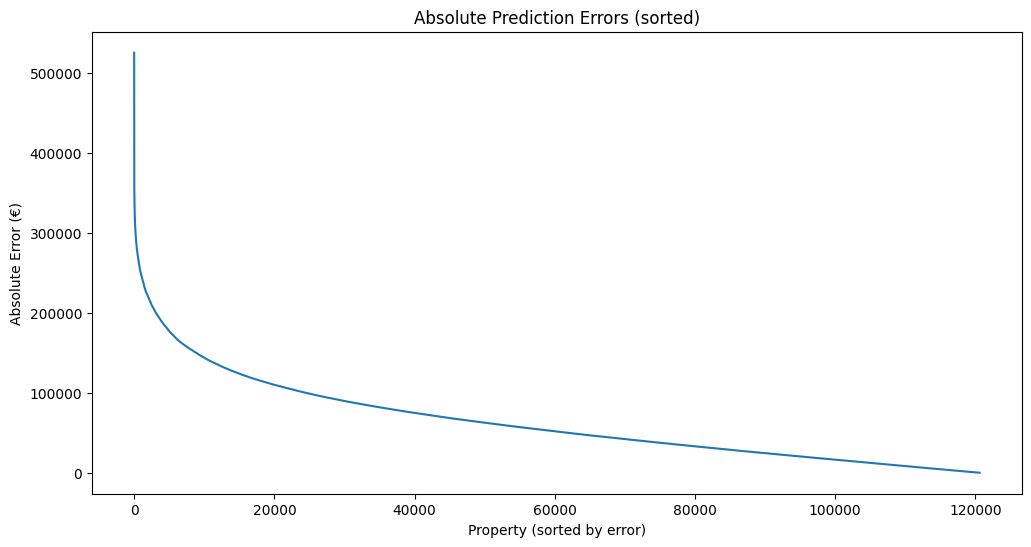

In [104]:
import matplotlib.pyplot as plt

# Plot absolute errors (sorted)
error_df_sorted = error_df.sort_values('abs_error', ascending=False).reset_index(drop=True)
plt.figure(figsize=(12,6))
plt.plot(error_df_sorted['abs_error'].values)
plt.title('Absolute Prediction Errors (sorted)')
plt.xlabel('Property (sorted by error)')
plt.ylabel('Absolute Error (€)')
plt.show()


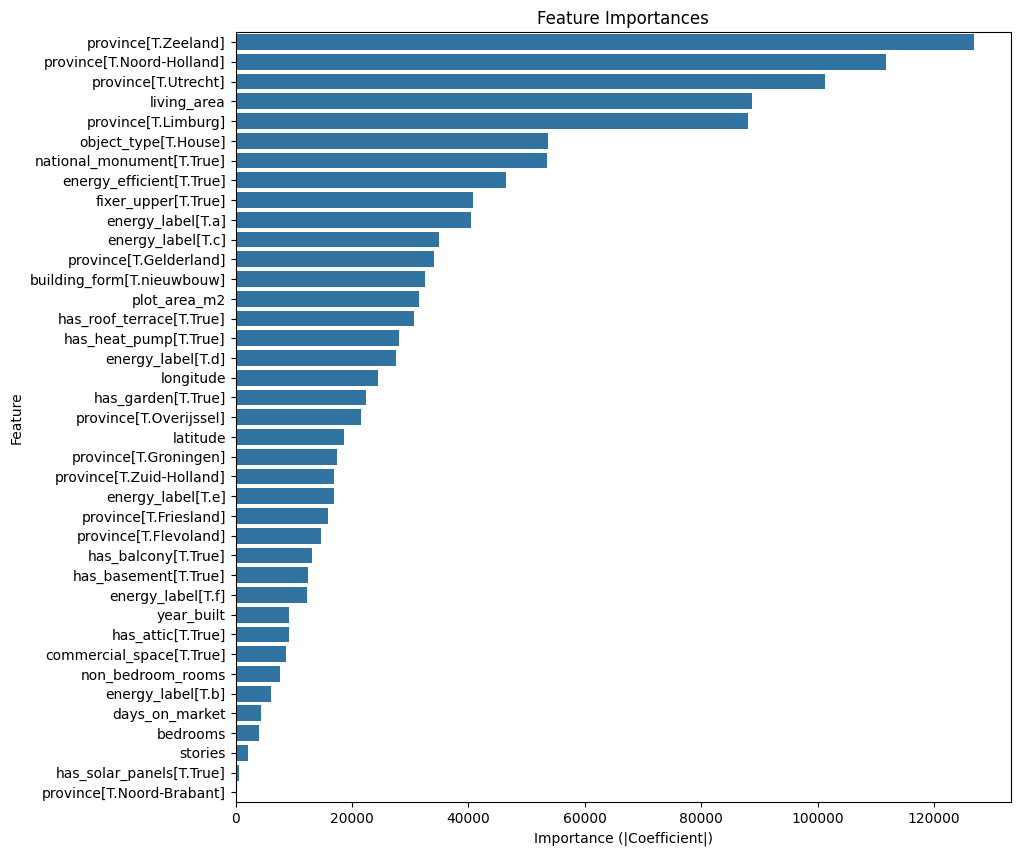

In [106]:
import matplotlib.pyplot as plt
import seaborn as sns

# Get feature importances from the statsmodels OLS model, excluding Intercept
importance = np.abs(model.params)
feature_names = model.params.index

# Exclude Intercept
mask = feature_names != "Intercept"
feature_importance_df = pd.DataFrame({
    'feature': feature_names[mask],
    'importance': importance[mask]
}).sort_values(by='importance', ascending=False)#.head(25)

# Plot top 10 feature importances (without Intercept)
plt.figure(figsize=(10, 10))
sns.barplot(x='importance', y='feature', data=feature_importance_df)
plt.title('Feature Importances')
plt.xlabel('Importance (|Coefficient|)')
plt.ylabel('Feature')
plt.show()